# New Mexico Oil and Gas Field Spill Incidents Machine Learing

The New Mexico oil and gas field spills data collected by Oil Conversation Division (https://wwwapps.emnrd.state.nm.us/ocd/ocdpermitting/Data/Spills/Spills.aspx) is used to predict the missing incident severity through supervised classification machine learning. This document is submitted to my GitHub account together with file "Capstone_project1_machine_learning.pdf".

In [19]:
# import libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

sns.set()

## Data Import and Wrangling

Import the table of spills containing oil and gas field spills data in New Mexico, and the columns are going to be analyzed are: 
+ Facility: facility identifier if the incident happened in a facility
+ API: well identifier if the incident happened in a well
+ Operator Name
+ Severity
+ Incident Type
+ Material Spilled
+ Volume Spilled
+ Volume Recovered
+ Spill Cause
+ Spill Source
+ District
+ County
+ Waterway Affected
+ Ground Water Impact

Forward and backward fill the NaNs in the table with the information of the same incident, and drop duplicated rows.

In [20]:
# import spills.csv and fill NaNs for rows having the same incident number, drop duplicates 
spills = pd.read_csv('spills.csv')
spills = spills.groupby('Incident Number').ffill().groupby('Incident Number').bfill()
spills = spills.drop_duplicates()

## Exploratory Data Analysis

From the EDA in the previous inferential statistics study, it's found that there are 4183 the missing values of incident severity out of 26454 rows. 

And in the following section, I'm going to apply supervised machine learning to get the missing data of incident severity, and regenerate the correlation plots to compare with the plots in previous section.

## Machine Learning

To predict the missing incident severity (major or minor) based on the known incident severity and its features, first I reset the table index to update the missing values once they are predicted. The incident features applied for machine learning are: whether the incident happened in a facility or well, the incident type, material spilled, volume spilled, spill cause, spill source, waterway affected or not, ground water impacted or not. 

Then convert the columns of data type from string categories to integer identifiers. From the seaborn pairplot plot below, I can assume that the features are independent and qualified to do machine learning analysis, as there is no clear correlation pattern between each other. 

In [21]:
# select the columns of data from machine learning
spills_tran = spills.reset_index(drop=True).reset_index()
spills_tran = spills_tran.loc[:,['index','Facility', 'API', 'Severity', 'Incident Type', 'Material Spilled', 'Volume Spilled', 'Spill Cause', 'Spill Source', 'Waterway Affected', 'Ground Water Impact']]

In [22]:
# convert the columns of categories to numerical identifiers
for col in ['Incident Type', 'Material Spilled', 'Spill Cause', 'Spill Source']:
    items = list(spills_tran[col].unique())
    dic = {}
    for i in range(len(items)):
        dic[items[i]] = i+1
    spills_tran[col+' '+'Code'] = spills_tran[col].apply(lambda x: dic[x])

In [23]:
# convert the columns of categories to numerical identifiers
spills_tran['Facility Code'] = spills_tran['Facility'].apply(lambda x: 0 if x is np.nan else 1)
spills_tran['Well Code'] = spills_tran['API'].apply(lambda x: 0 if x is np.nan else 1)
spills_tran['Waterway Affected Code'] = spills_tran['Waterway Affected'].apply(lambda x: 0 if x=='No' else 1)
spills_tran['Ground Water Impact Code'] = spills_tran['Ground Water Impact'].apply(lambda x: 0 if x=='No' else 1)

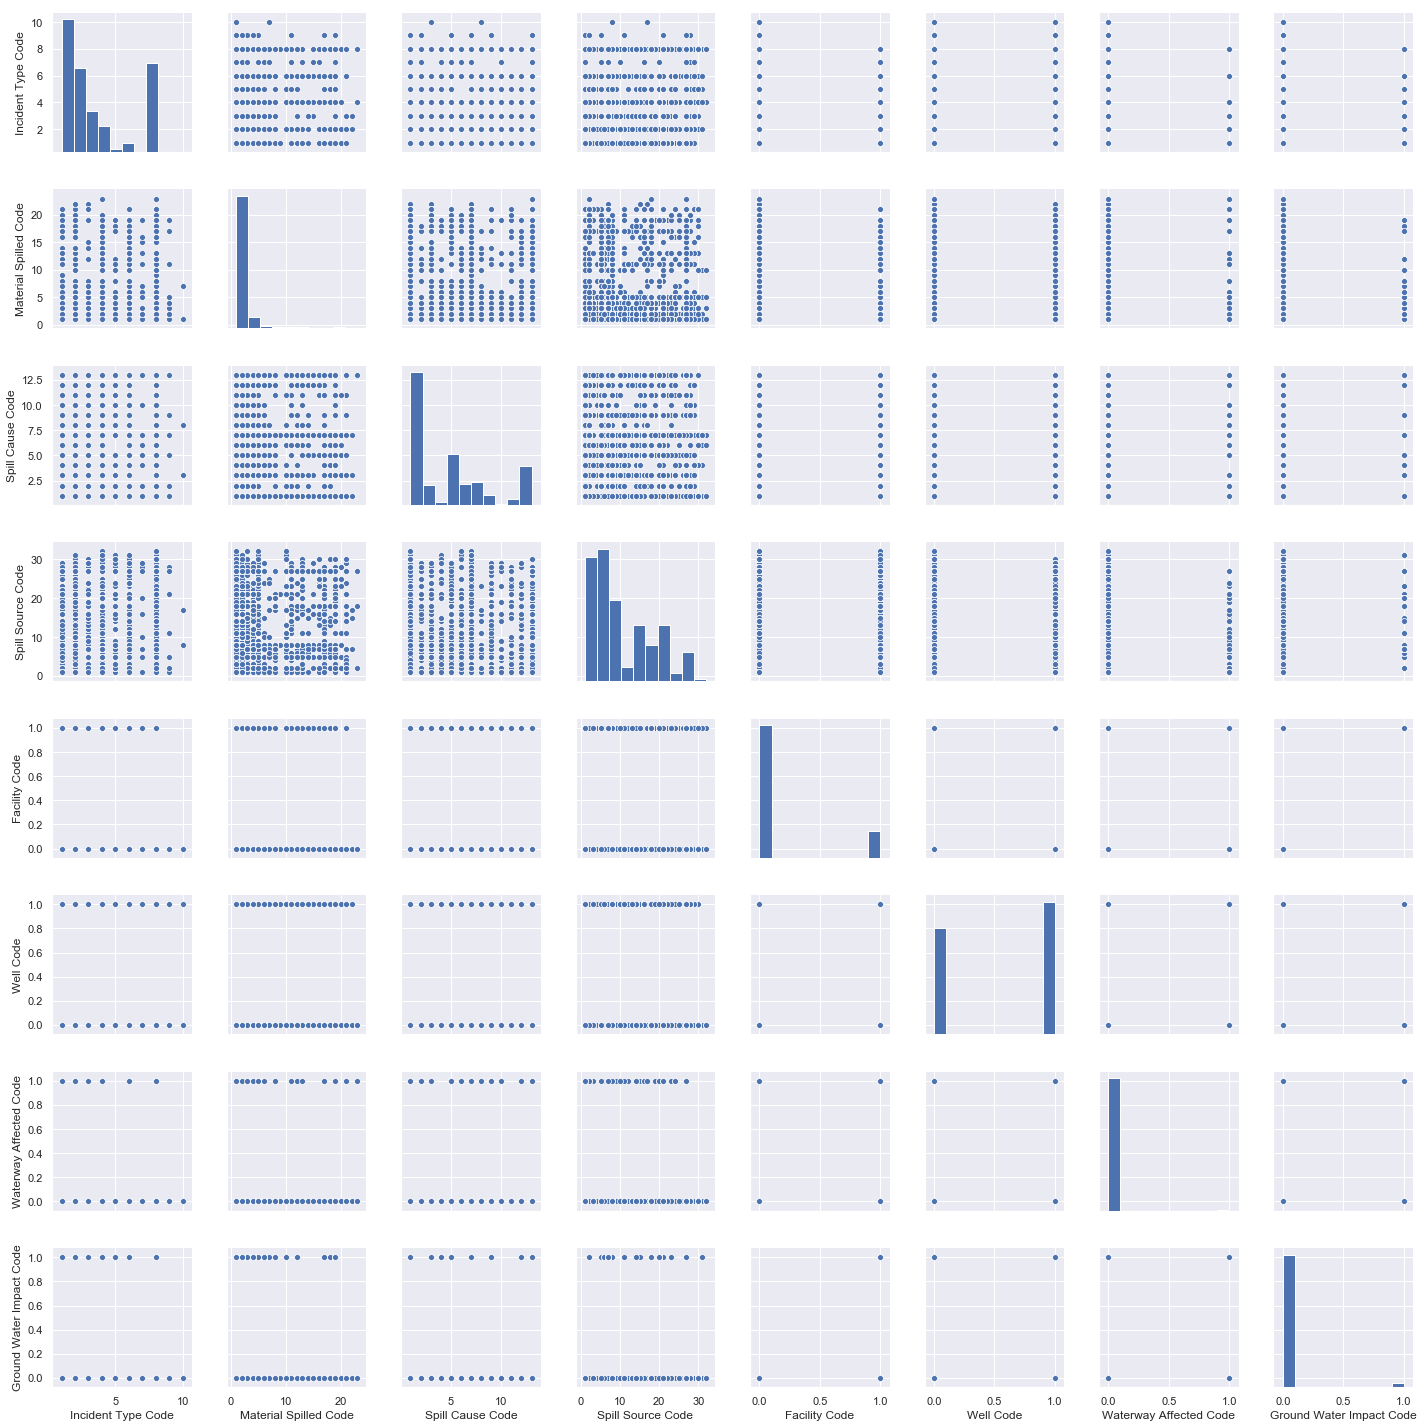

In [24]:
# delete the original non-numerical columns and general a pairplot of converted categorical columns
spills_tran = spills_tran.drop(['Facility','API','Incident Type', 'Material Spilled', 'Spill Cause', 'Spill Source','Waterway Affected','Ground Water Impact'],axis=1)
sns.pairplot(data=spills_tran.drop(['index','Severity','Volume Spilled'],axis=1))

The data is split into two parts, that the known incident severity and features are used to train the model. I'm choosing the KNeighborsClassifier to conduct the supervised classification machine learning. *X_severity_given* contains the features and *y_severity_given* contains the results. `train_test_split` function is used to split the train the train and test data with *20%* test size, and use `GridSearchCV` to tune and cross validate the parameter `n_neighbors`. After training the model, I get 92.5% accuracy score for train data and 86.1% accuracy score for test data, with the best `n_neighbors`=2. 

From the following plots of the train data residual distribution and the test data residual distribution, we can see the residual distribution uniformly in 1 and -1 around 0, which further validates the model. 

Then apply the trained model to predict the missing incident severity data, and the initial spills table is updated, and the correlations are re-evaluated among the monthly number of incidents, volume spilled and recovered, severity, incident type, material spilled, cause, source, waterway and ground water impacted, location distribution, and operators.

In [25]:
# split the data to two parts: known and missing incident severity
severity_given = spills_tran[spills_tran['Severity'].notnull()]
severity_not_given = spills_tran[spills_tran['Severity'].isnull()]
severity_given['Severity Code'] = severity_given['Severity'].apply(lambda x: 1 if x=='Major' else 0)

C:\Users\Jing\Anaconda3\envs\ipykernel_py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [26]:
# use the known severity data to train the model, tune the parameter, and calculate the accuracy score and best parameter 
X_severity_given = severity_given.drop(['Severity','Severity Code','index'],axis=1)
y_severity_given = severity_given['Severity Code']
X_train, X_test, y_train, y_test = train_test_split(X_severity_given,y_severity_given,test_size=0.2,random_state=5)
param_grid = {'n_neighbors':np.arange(1,50)}
clf = KNeighborsClassifier()
clf_cv = GridSearchCV(clf, param_grid, cv=5)
clf_cv.fit(X_train, y_train)
print("The accuracy score of the train data is: ",accuracy_score(clf_cv.predict(X_train), y_train))
print("The accuracy score of the test data is: ",accuracy_score(clf_cv.predict(X_test), y_test))
print("The best n_neighbors is: ",clf_cv.best_params_['n_neighbors'])

The accuracy score of the train data is:  0.9247867085765604
The accuracy score of the test data is:  0.8606060606060606
The best n_neighbors is:  2


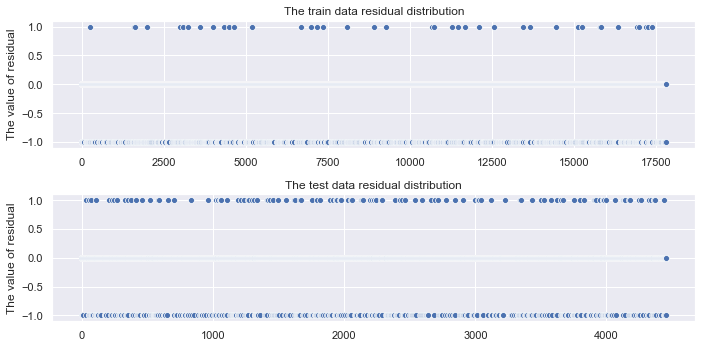

In [27]:
# plot the residuals to validate the model
fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(10,5))
ax[0] = sns.scatterplot(x=np.arange(len(y_train)),y=clf_cv.predict(X_train) - y_train, ax=ax[0])
ax[0].set_ylabel('The value of residual')
ax[0].set_title('The train data residual distribution')

ax[1] = sns.scatterplot(x=np.arange(len(y_test)),y=clf_cv.predict(X_test) - y_test, ax=ax[1])
ax[1].set_ylabel('The value of residual')
ax[1].set_title('The test data residual distribution')
plt.tight_layout()

In [28]:
# predict the missing data of incident severity with the trained model
severity_not_given['Severity Code'] = clf_cv.predict(severity_not_given.drop(['Severity', 'index'],axis=1))
severity_not_given['Severity'] = severity_not_given['Severity Code'].apply(lambda x: 'Major' if x==1 else 'Minor')
spills['Severity'] = np.array(severity_not_given.merge(severity_given,how='outer').sort_values('index')['Severity'])

C:\Users\Jing\Anaconda3\envs\ipykernel_py3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Jing\Anaconda3\envs\ipykernel_py3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


After predicting the missing incident severity data, I apply random forest tree to calculate the incident feature importance. The ensemble method used is `ExtraTreesClassifier`, with the number of trees in forest `n_estimators=100` and Gini impurity criterion. `feature_importances_` and the standard deviation of `feature_importances_` are calculated. 

From the following feature ranking and feature importances plot, we can see that the volume spilled is the most important feature to decide the incidents is whether major or minor.   

Feature ranking:
1. Volume Spilled (0.690908)
2. Spill Source (0.085158)
3. Material Spilled (0.069254)
4. Spill Cause (0.055226)
5. Incident Type (0.051836)
6. Ground Water Impact (0.021439)
7. Facility (0.011686)
8. Waterway Affected (0.007529)
9. Well (0.006964)


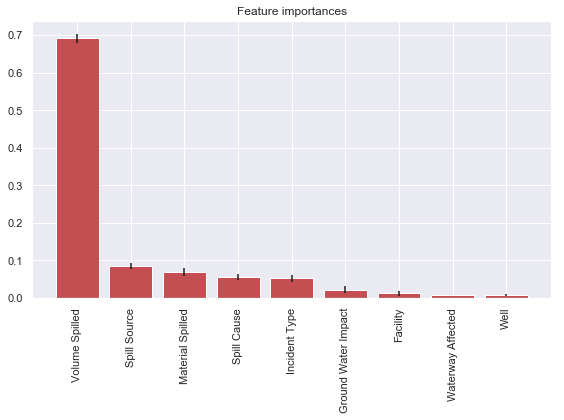

In [38]:
# get the updated spills data after predicting the missing incident severity
spills_updated = severity_not_given.merge(severity_given,how='outer')
X_spills_updated = spills_updated.drop(['index','Severity','Severity Code'], axis=1)
y_spills_updated = spills_updated['Severity Code']

from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=100, random_state=0)

forest.fit(X_spills_updated, y_spills_updated)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
features = [item[:-5] if item.endswith(' Code') else item for item in list(X_spills_updated.columns)]
features_sort = []
for f in range(X_spills_updated.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    features_sort.append(features[indices[f]])

# Plot the feature importances of the forest
plt.figure(figsize=(8,6))
plt.title("Feature importances")
plt.bar(features_sort, importances[indices], color='r', yerr=std[indices])
plt.xticks(rotation=90)
plt.tight_layout()

In [30]:
# conver the incident date to be datetime, and set it as the index of the table 
spills['Incident Date'] = pd.to_datetime(spills['Incident Date'])
spills.index = spills['Incident Date']
# group the major and minor incident monthly
spills_major = spills[spills['Severity']=='Major'].resample('M')['Severity'].count().reset_index()
spills_major = spills_major.rename(columns={'Severity':'Incident Number'})
spills_major['Severity'] = 'Major'
spills_minor = spills[spills['Severity']=='Minor'].resample('M')['Severity'].count().reset_index()
spills_minor = spills_minor.rename(columns={'Severity':'Incident Number'})
spills_minor['Severity'] = 'Minor'
spills_major_minor = spills_major.append(spills_minor)

After updating, there monthly number of incidents increases by 10 to 20/month after 2008, and maximum number of major and minor incidents is more than 120/month in 2016 with more minor incidents than major incidents.

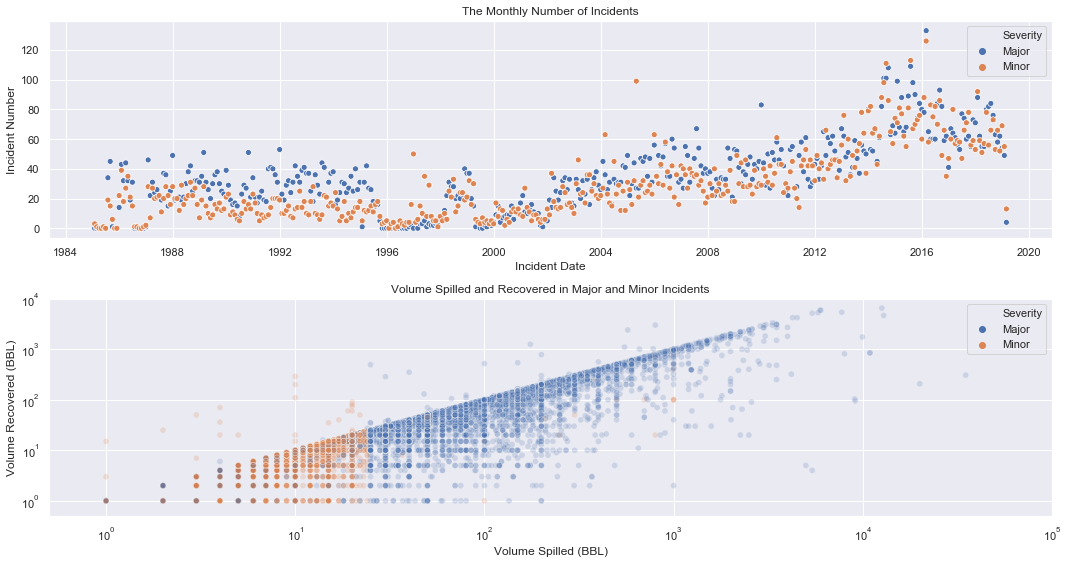

In [31]:
# plot the monthly number of incidents and spilled volume of incidents
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15, 8))
ax[0] = sns.scatterplot(x='Incident Date', y='Incident Number', hue='Severity', data=spills_major_minor[spills_major_minor['Incident Date']>pd.to_datetime(str(19850101))], ax=ax[0])
ax[0].set_title('The Monthly Number of Incidents')

ax[1] = sns.scatterplot(x='Volume Spilled', y='Volume Recovered',hue='Severity',hue_order=['Major','Minor'], data=spills, alpha=0.2, ax=ax[1])
ax[1].set_xlim([0.5,1e5])
ax[1].set_ylim([0.5,1e4])
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Volume Spilled (BBL)')
ax[1].set_ylabel('Volume Recovered (BBL)')
ax[1].set_title('Volume Spilled and Recovered in Major and Minor Incidents')
plt.tight_layout()

From the correlation between monthly major and minor incidents, we can see the maximum monthly number of minor incidents is more than major incidents after updating the table.

Text(0.5, 1.0, 'The Correlation between Monthly Major and Minor Incidents')

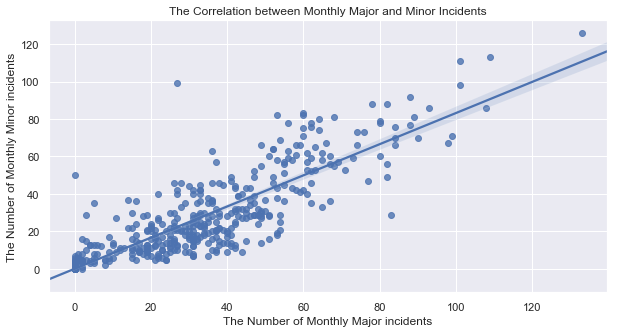

In [32]:
# plot the correlation of monthly major and minor incidents
spills_major_minor_merge = spills_major.drop('Severity',axis=1).rename(columns={'Incident Number':'Major'}).merge(spills_minor.drop('Severity',axis=1).rename(columns={'Incident Number':'Minor'}),how='outer').fillna(0)
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.regplot(spills_major_minor_merge['Major'],spills_major_minor_merge['Minor'])
ax.set_xlabel('The Number of Monthly Major incidents')
ax.set_ylabel('The Number of Monthly Minor incidents')
ax.set_title('The Correlation between Monthly Major and Minor Incidents')

From the following plots of the correlation between the number of major and minor incidents and incident type, material spilled, spill cause and spill source, it's showing that the number of minor and major incidents of each category is adjusted slightly and reordered. 

In [33]:
# major and minor incidents distribution in incident type, spilled material, spilled cause, spilled source, groud water impact and waterway affected
incident_type = spills.groupby(['Incident Type','Severity'])['Incident Number'].count().sort_values(ascending=False).reset_index()
spill_material = spills.groupby(['Material Spilled','Severity'])['Incident Number'].count().sort_values(ascending=False).reset_index()
spill_cause = spills.groupby(['Spill Cause','Severity'])['Incident Number'].count().sort_values(ascending=False).reset_index()
spill_source = spills.groupby(['Spill Source','Severity'])['Incident Number'].count().sort_values(ascending=False).reset_index()
ground_water_impact = spills.groupby(['Ground Water Impact','Severity'])['Incident Number'].count().sort_values(ascending=False).reset_index()
waterway_affected = spills.groupby(['Waterway Affected','Severity'])['Incident Number'].count().sort_values(ascending=False).reset_index()

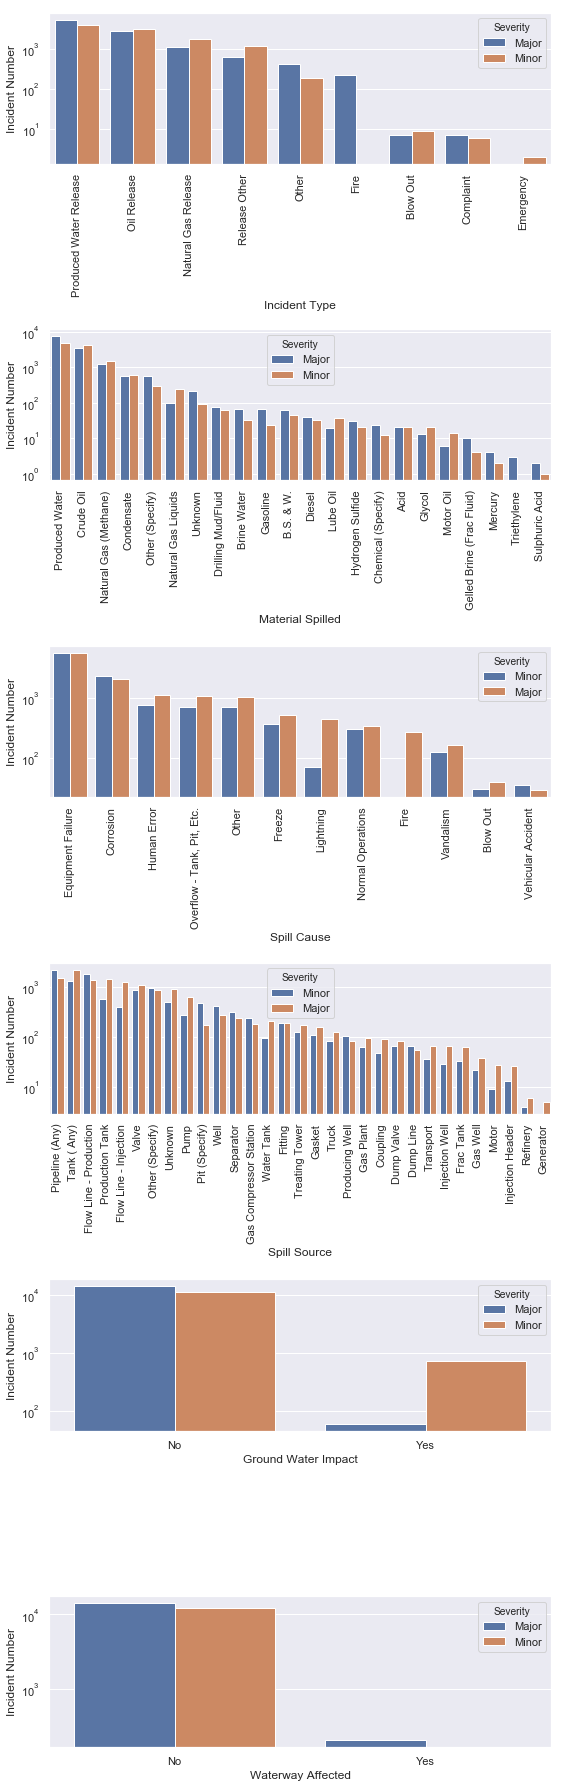

In [34]:
# plot major and minor incidents distribution in incident type, spilled material, spilled cause, spilled source, groud water impact and waterway affected
fig, ax = plt.subplots(nrows=6, ncols=1,figsize=(8, 25))

ax[0] = sns.barplot(x='Incident Type',y='Incident Number', hue='Severity' ,data=incident_type, ax=ax[0])
ax[0].set_yscale('log')
plt.setp(ax[0].get_xticklabels(), rotation=90)

ax[1] = sns.barplot(x='Material Spilled',y='Incident Number', hue='Severity' ,data=spill_material, ax=ax[1])
ax[1].set_yscale('log')
plt.setp(ax[1].get_xticklabels(), rotation=90)

ax[2] = sns.barplot(x='Spill Cause',y='Incident Number',hue='Severity', data=spill_cause, ax=ax[2])
ax[2].set_yscale('log')
plt.setp(ax[2].get_xticklabels(), rotation=90)

ax[3] = sns.barplot(x='Spill Source',y='Incident Number',hue='Severity', data=spill_source, ax=ax[3])
ax[3].set_yscale('log')
plt.setp(ax[3].get_xticklabels(), rotation=90)

ax[4] = sns.barplot(x='Ground Water Impact',y='Incident Number',hue='Severity', data=ground_water_impact, ax=ax[4])
ax[4].set_yscale('log')

ax[5] = sns.barplot(x='Waterway Affected',y='Incident Number',hue='Severity', data=waterway_affected, ax=ax[5])
ax[5].set_yscale('log')
plt.tight_layout()

The number of incidents in each district and county is adjusted slightly and reordered. 

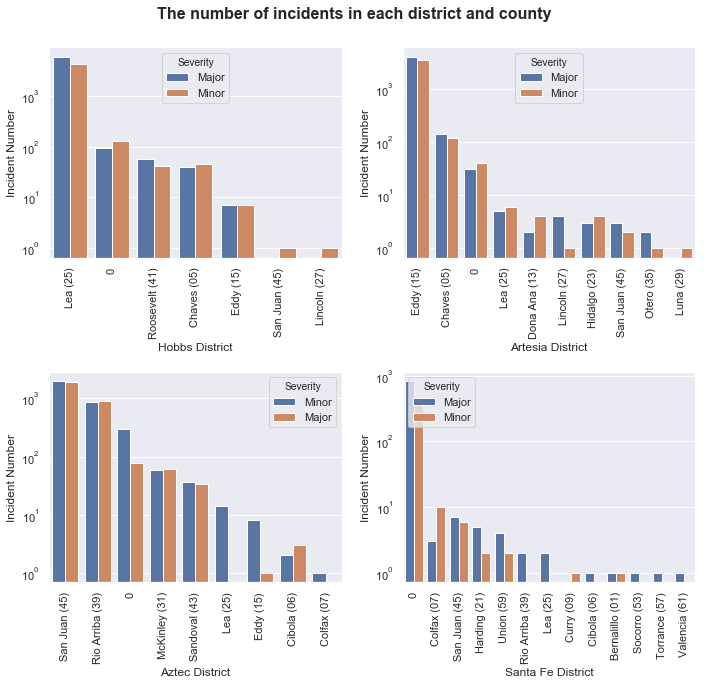

In [35]:
# major and minor incidents happened in each district and county
district_county = spills.groupby(['District','County', 'Severity'])['Incident Number'].count().sort_values(ascending=False).reset_index()
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10, 10))

ax[0,0] = sns.barplot(x='County',y='Incident Number', hue='Severity' ,data=district_county[district_county['District']=='Hobbs'], ax=ax[0,0])
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('Hobbs District')
plt.setp(ax[0,0].get_xticklabels(), rotation=90)

ax[0,1] = sns.barplot(x='County',y='Incident Number', hue='Severity' ,data=district_county[district_county['District']=='Artesia'], ax=ax[0,1])
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('Artesia District')
plt.setp(ax[0,1].get_xticklabels(), rotation=90)

ax[1,0] = sns.barplot(x='County',y='Incident Number', hue='Severity' ,data=district_county[district_county['District']=='Aztec'], ax=ax[1,0])
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('Aztec District')
plt.setp(ax[1,0].get_xticklabels(), rotation=90)

ax[1,1] = sns.barplot(x='County',y='Incident Number', hue='Severity' ,data=district_county[district_county['District']=='Santa Fe'], ax=ax[1,1])
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('Santa Fe District')
plt.setp(ax[1,1].get_xticklabels(), rotation=90)

plt.suptitle('The number of incidents in each district and county', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

The total number of minor incidents caused by operators increases after updating the data, for example, COG OPERATING LLC, ENTERPRISE PRODUCTS OPERATING LLC, BP AMERICA PRODUCTION COMPANY.

Text(0.5, 1.0, 'The Total Number of Major and Minor Incidents from Each Operator')

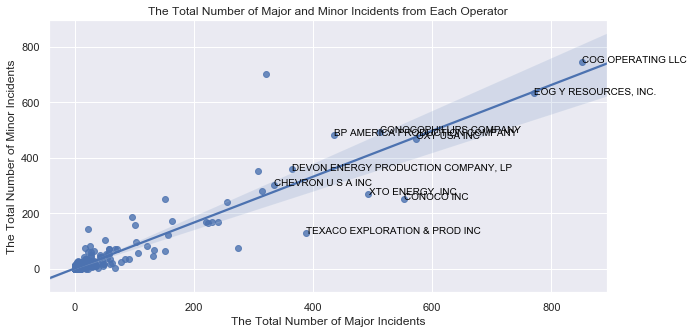

In [36]:
# correlation of major and minor incidents among the operators
operator = pd.DataFrame(spills.groupby('Severity')['Operator Name'].value_counts()).unstack(level=0).reset_index()
operator.columns = ['_'.join(col) for col in operator.columns]
operator.columns = ['Operator Name','Major','Minor']
operator = operator.fillna(0).sort_values('Major', ascending=False).reset_index()

fig, ax = plt.subplots(figsize=(10,5))
ax=sns.regplot(operator['Major'],operator['Minor'],data=operator)
for line in range(0,10):               
     ax.text(operator.Major[line]+0.2, operator.Minor[line], operator['Operator Name'][line], horizontalalignment='left', size='small', color='black')#, weight='semibold')
ax.set_xlabel('The Total Number of Major Incidents')
ax.set_ylabel('The Total Number of Minor Incidents')
ax.set_title('The Total Number of Major and Minor Incidents from Each Operator')


## Conclusion

+ Assuming independent features of the incidents, the KNeighborsClassifier model is applied to conduct the supervised classification machine learning. After tuning and cross validating the parameter `n_neighbors`, I get 92.5% accuracy score for train data and 86.1% accuracy score for test data, with the best `n_neighbors`=2. 

+ The volume spilled is the most important feature to decide the incidents is whether major or minor.

+ From the plots of the train data residual distribution and the test data residual distribution, we can see the residual distribution uniformly in 1 and -1 around 0, which further validates the model. 

+ Then apply the trained model to predict the missing incident severity data, and update the initial spills table, and the corrolations are re-evaluated among the monthly number of incidents, volume spilled and recovered, severity, incident type, material spilled, cause, source, waterway and ground water impacted, location distribution, and operators.

+ After updating, there monthly number of incidents increases by 10 to 20/month after 2008, and maximum number of major and minor incidents is more than 120/month in 2016 with more minor incidents than major incidents.
+ The maximum monthly number of minor incidents is more than major incidents after updating the table.
+ The correlation between the number of major and minor incidents and incident type, material spilled, spill cause and spill source is adjusted slightly and reordered on each category. 
+ The number of incidents in each district and county is adjusted slightly. 
+ The total number of minor incidents caused by opertors increases after updating the data, for example, COG OPERATING LLC, ENTERPRISE PRODUCTS OPERATING LLC, BP AMERICA PRODUCTION COMPANY.

## Future Work
+ Does minor incident tends to lead major incident without correction
+ Incident per bbl or MFC oil /gas production